# <center> Проект: классификация

Вам предоставили данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Вы должны проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если вы сможете это сделать, то поднимете доходы банка и поможете понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

Бизнес-задача: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

Техническая задача для вас как для специалиста в Data Science: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('/home/aleksandr/Документы/GitHub/data/ML8/bank_fin.csv', sep = ';')
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes


Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке.

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [3]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [3]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
data = df.copy()

In [4]:
def replace_symb(x):
    x = str(x)
    for symb in ['$', ',00', ' ']:
        x = x.replace(symb, '')
    return float(x)

data['balance'] = data['balance'].apply(replace_symb)
round(data['balance'].mean(), 3)

1529.129

### Задание 4

In [5]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
data['balance'] = data['balance'].fillna(data['balance'].median())
round(data['balance'].mean(), 3)

1526.936

### Задание 5

In [6]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
data['job'] = data['job'].apply(lambda x: data['job'].mode()[0] if x == 'unknown' else x)
data['education'] = data['education'].apply(lambda x: data['education'].mode()[0] if x == 'unknown' else x)

In [7]:
# После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования.
# Ответ округлите до трёх знаков после точки-разделителя.

# round(data.groupby(['job','education'])['balance'].agg('mean')[data['job'].mode()[0],data['education'].mode()[0]],3)
df_new = data[(data['job'] == 'management') & (data['education'] == 'secondary')]
df_new['balance'].mean()

1598.8829787234042

### Задание 6

In [8]:
# удалите все выбросы для признака balance. Изучите признак, отображающий баланс клиентов, на предмет выбросов.
# В математической статистике есть несколько подходов, позволяющих определить наличие выбросов.
# Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли
# полтора межквартильных размаха (\(Q1 - 1.5 * IQR\)) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха.
# (\(Q3 + 1.5 * IQR\)). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

q_1, q_3 = data['balance'].quantile(0.25), data['balance'].quantile(0.75)
iqr = q_3 - q_1
lower_bound = q_1 - 1.5*iqr
upper_bound = q_3 + 1.5*iqr

df_cleaned = data[(data['balance'] >= lower_bound)&(data['balance'] <= upper_bound)]

print('Нижняя граница:', round(lower_bound))
print('Верхняя граница:', round(upper_bound))
print('Общее число данных:', df_cleaned.shape[0])

Нижняя граница: -2241
Верхняя граница: 4063
Общее число данных: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

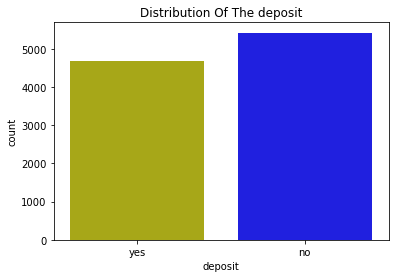

In [205]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
pl = sns.countplot(df_cleaned["deposit"], palette=['y', 'b'])
pl.set_title("Distribution Of The deposit")
plt.show()

In [206]:
df_cleaned["deposit"].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задание 2

In [28]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df_cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


<Figure size 432x288 with 0 Axes>

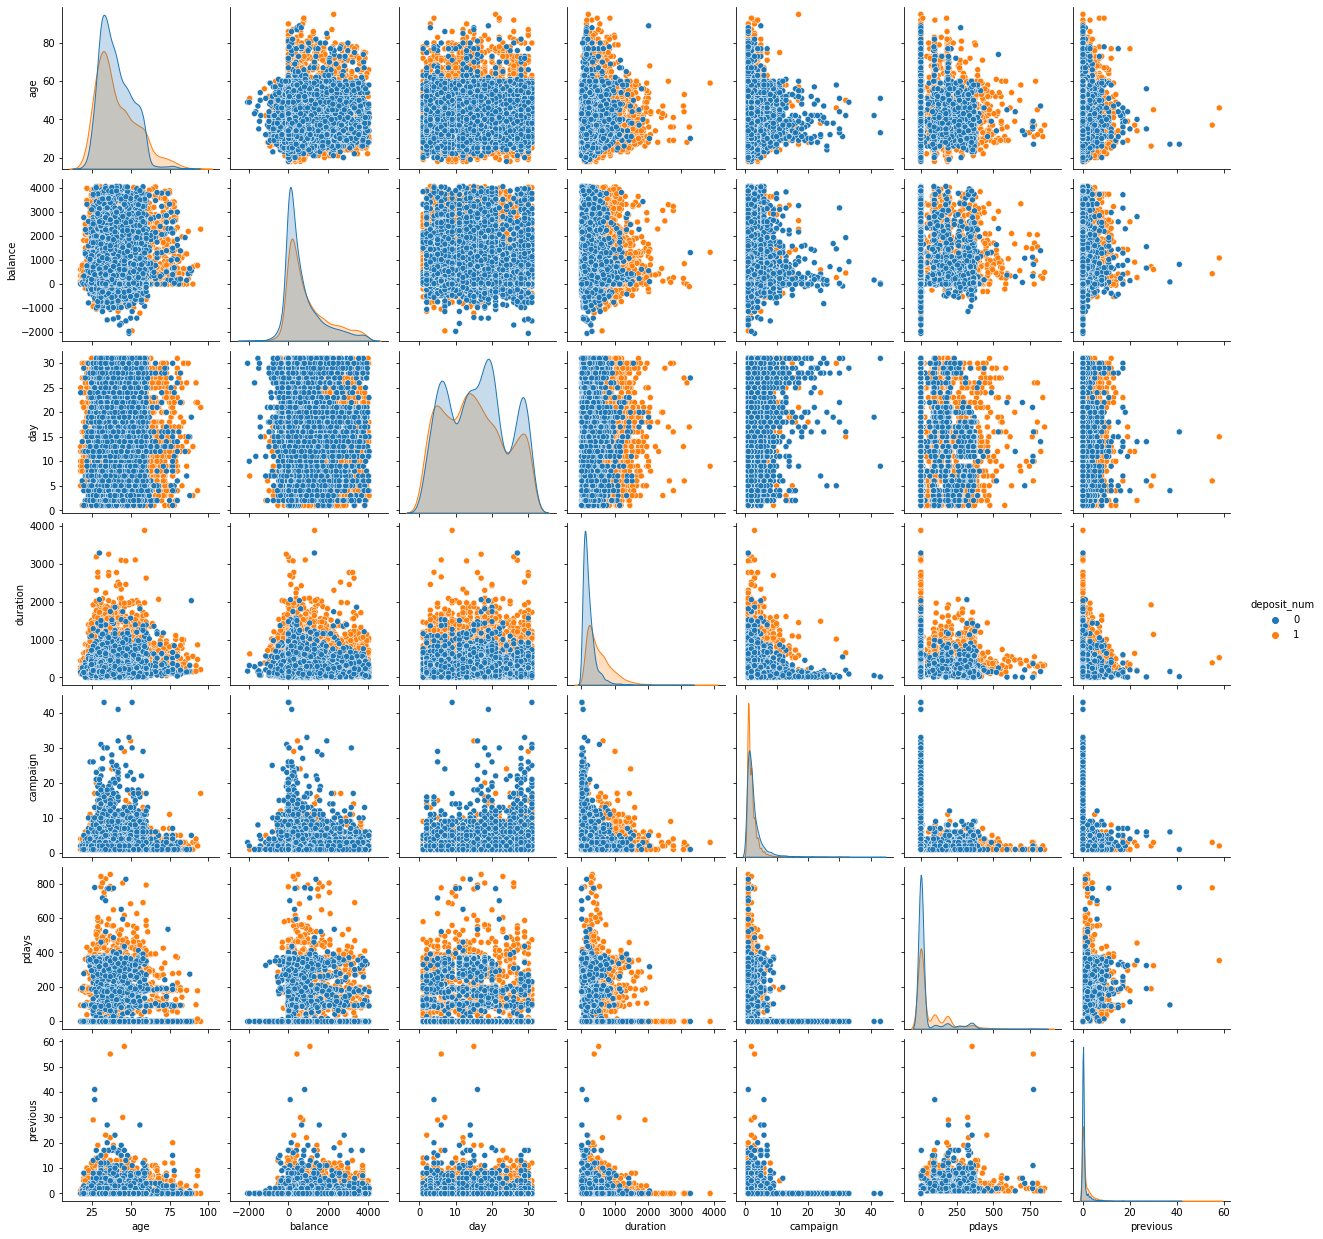

In [215]:
df_cleaned_copy = df_cleaned.copy()
df_cleaned_copy['deposit_num'] = df_cleaned_copy['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
to_plot = ["age", "balance", "day", "duration", "campaign", "pdays", 'previous', 'deposit_num']
plt.figure()
sns.pairplot(df_cleaned_copy[to_plot], hue= "deposit_num")
plt.show()

### Задание 3

In [29]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат. постройте визуализации, иллюстрирующие результаты

# Сколько было месяцев, в которых проводилась маркетинговая кампания?
df_cleaned['month'].nunique()
# Сколько сфер занятости представлено среди клиентов банка?
df_cleaned['job'].nunique()

11

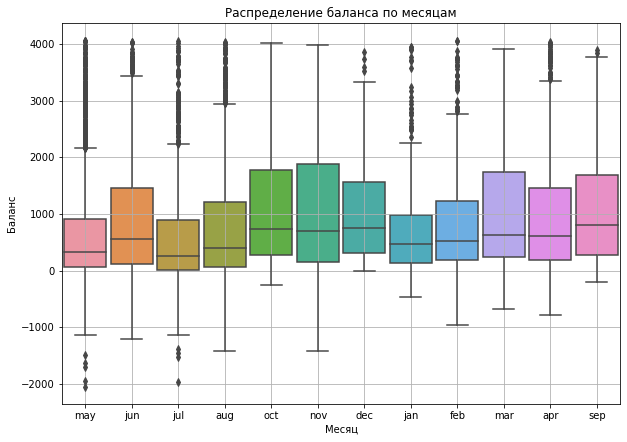

In [30]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=df_cleaned,
    y='balance',
    x='month',
    orient='v',
    width=0.9
)
boxplot.set_title('Распределение баланса по месяцам');
boxplot.set_xlabel('Месяц');
boxplot.set_ylabel('Баланс');
boxplot.grid()

### Задание 4

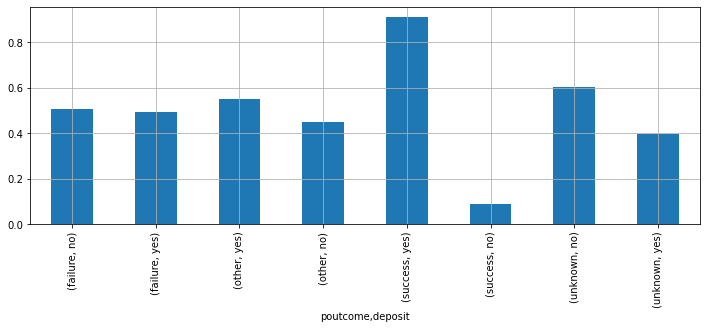

In [31]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df_poutcome = df_cleaned.groupby("poutcome")['deposit'].value_counts(normalize=True)
df_poutcome.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4)
);

### Задание 5

In [9]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df_cleaned[df_cleaned.deposit == 'no'].groupby(['month'])['deposit'].count().idxmax()

'may'

### Задание 6

In [10]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(age):
    if age<30:
        age = '<30'
    elif age>=30 and age<40:
        age = '30-40' 
    elif age>=40 and age<50:
        age = '40-50' 
    elif age>=50 and age<60:
        age = '50-60' 
    else: age = '60+'
    return age

df_cleaned['age_group'] = df_cleaned['age'].apply(age_group)

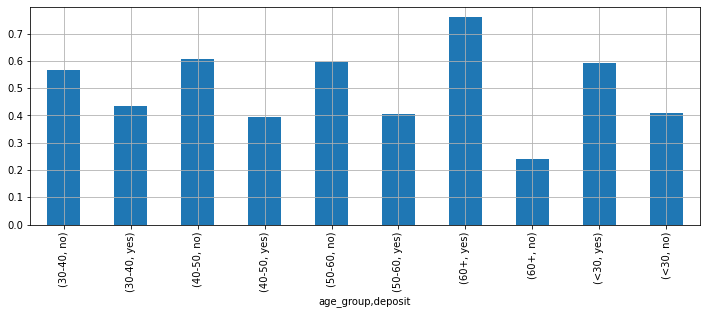

In [33]:
df1 = df_cleaned.groupby("age_group")['deposit'].value_counts(normalize=True)
df1.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4)
);

### Задание 7

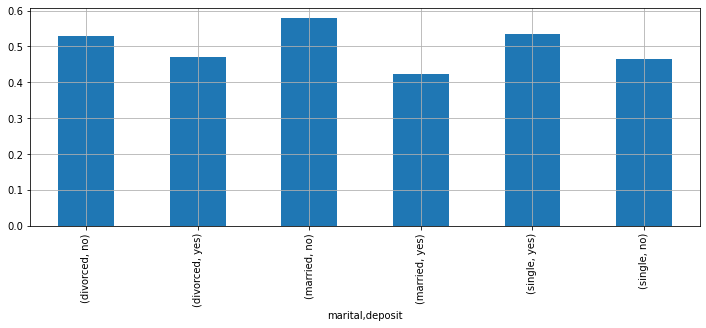

In [40]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df1 = df_cleaned.groupby("marital")['deposit'].value_counts(normalize=True)
df1.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4)
);

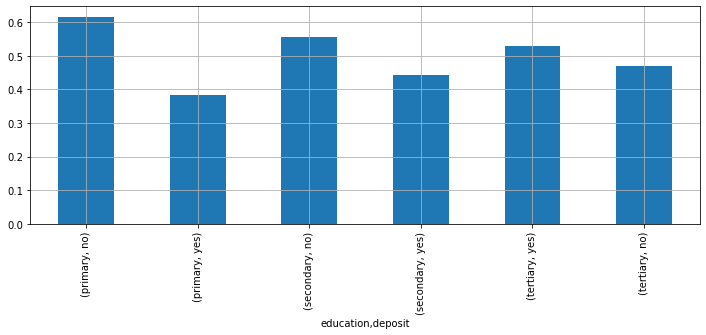

In [42]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df1 = df_cleaned.groupby("education")['deposit'].value_counts(normalize=True)
df1.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4)
);

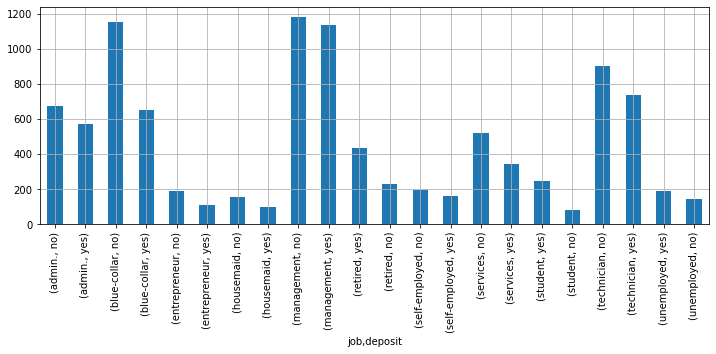

In [44]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df1 = df_cleaned.groupby("job")['deposit'].value_counts(normalize=False)
df1.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4)
);

### Задание 8

In [13]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

df_yes = df_cleaned[df_cleaned.deposit == 'yes']
df_no = df_cleaned[df_cleaned.deposit == 'no']

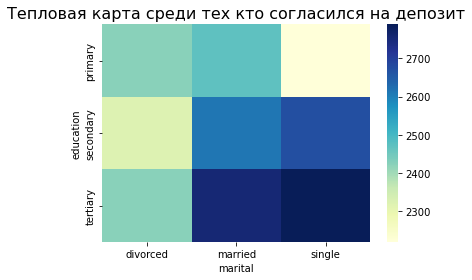

In [97]:
pivot = df_yes.pivot_table(
    values = 'index',
    columns = 'marital',
    index = 'education',
)
pivot.columns = pivot.columns.astype('string')

heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта среди тех кто согласился на депозит', fontsize=16);

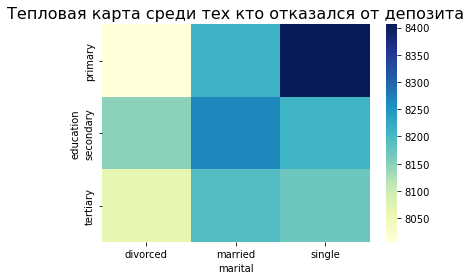

In [96]:
pivot = df_no.pivot_table(
    values = 'index',
    columns ='marital',
    index = 'education',
)
pivot.columns = pivot.columns.astype('string')

heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта среди тех кто отказался от депозита', fontsize=16);

## Часть 3: преобразование данных

### Задание 1

In [11]:
# преобразуйте уровни образования
le = LabelEncoder()
df_cleaned['education'] = le.fit_transform(df_cleaned['education'])
df_cleaned['age_group'] = le.fit_transform(df_cleaned['age_group'])
df_cleaned['education'].sum()

11995

### Задание 2

In [12]:
# преобразуйте бинарные переменные в представление из нулей и единиц
def binary_coding(x):
    if x == 'yes':
        x = 1
    else: x=0
    return x
    
df_cleaned['default'] = df_cleaned['default'].apply(binary_coding)
df_cleaned['housing'] = df_cleaned['housing'].apply(binary_coding)
df_cleaned['loan'] = df_cleaned['loan'].apply(binary_coding)
df_cleaned['deposit'] = df_cleaned['deposit'].apply(binary_coding)
df_cleaned.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1


### Задание 3

In [13]:
# создайте дамми-переменные
df_dummy = df_cleaned[['job', 'marital', 'contact', 'month', 'poutcome']]
df_get_dummies = pd.get_dummies(df_dummy)
df_new = pd.concat([df_cleaned, df_get_dummies], axis=1)
len(df_new.columns)

51

### Задание 4

In [38]:
#fig, ax = plt.subplots(figsize=(20,20))
#sns.heatmap(df_new.corr(), annot=True, linewidths=.5, ax=ax)

### Задание 5

In [14]:
#Удалим категориальные признаки
df_new = df_new.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)

In [15]:
X = df_new.drop(['deposit'], axis=1)
y = df_new['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 6

In [16]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

skb_features = selector.get_feature_names_out()

X_train_skb = X_train[skb_features]
X_test_skb = X_test[skb_features]

### Задание 7

In [17]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_skb)

X_train_scaled = pd.DataFrame(scaler.transform(X_train_skb), columns= skb_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_skb), columns= skb_features)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [25]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

#print('Accuracy: {:.2f}'.format(classification_report(y_test, y_test_pred)))
#print("accuracy на тестовом наборе: {:.2f}".format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

accuracy на тестовом наборе: 0.80


### Задание 2

In [26]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42)
dt.fit(X_train_scaled, y_train)
y_test_pred = dt.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1790
           1       0.74      0.71      0.72      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.74      0.75      3335
weighted avg       0.75      0.75      0.75      3335



### Задание 3

In [33]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': list(np.linspace(1, 10, dtype=int))}
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  

grid_search_tree.fit(X_train_scaled, y_train) 
y_test_pred = grid_search_tree.predict(X_test_scaled)

print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))
print(metrics.classification_report(y_test, y_test_pred))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7}
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



In [39]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3,5,7],
              'min_samples_split': [2, 5, 7, 10]}
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  

grid_search_tree.fit(X_train_scaled, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

dt = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=7, min_samples_split=2, random_state=42)
dt.fit(X_train_scaled, y_train)
y_test_pred = dt.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [67]:
# обучите на ваших данных случайный лес
from sklearn.metrics import classification_report

rf = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', min_samples_leaf=5, max_depth=10, random_state=42)

rf.fit(X_train_scaled, y_train)
y_test_pred = rf.predict(X_test_scaled)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 2

In [65]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    max_depth=5,
    n_estimators=300,
    min_samples_leaf = 5,
    random_state=42 
)

gb.fit(X_train_scaled, y_train)
y_test_pred  = gb.predict(X_test_scaled)

print(classification_report(y_test, y_test_pred))

### Задание3

In [70]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ('dt', dt),
    ('log_reg',  log_reg),
    ('gb', gb)
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.RandomForestClassifier(random_state=42)
)
#Обучаем модель
reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [71]:
y_test_pred  = reg.predict(X_test_scaled)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 4

In [76]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

### Задание 5

In [83]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2022-06-28 15:14:27,494] A new study created in memory with name: RandomForestClassifier
[I 2022-06-28 15:14:28,422] Trial 0 finished with value: 0.8621389539422326 and parameters: {'n_estimators': 160, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8621389539422326.
[I 2022-06-28 15:14:29,253] Trial 1 finished with value: 0.8618853742561853 and parameters: {'n_estimators': 145, 'max_depth': 21, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8621389539422326.
[I 2022-06-28 15:14:30,017] Trial 2 finished with value: 0.8574108818011258 and parameters: {'n_estimators': 130, 'max_depth': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8621389539422326.
[I 2022-06-28 15:14:31,322] Trial 3 finished with value: 0.8773790951638065 and parameters: {'n_estimators': 197, 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8773790951638065.
[I 2022-06-28 15:14:32,083] Trial 4 finished with value: 0.8887149788699327 and parameters: {'n_

In [84]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 176, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.93


In [90]:
#rf = ensemble.RandomForestClassifier(n_estimators=176, max_depth=25, min_samples_leaf=2, random_state=42) 
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82


In [87]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [88]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")